Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
import pickle
import time
import seaborn as sns

PUNTO 2: EDA

1. Leer CSV

In [2]:
df_available = pd.read_csv("attrition_availabledata_03.csv")

2. Calculando el número de variables e instancias

In [3]:
print("\n🔹 Número de instancias y variables:")
print(f"Filas: {df_available.shape[0]}, Columnas: {df_available.shape[1]}")


🔹 Número de instancias y variables:
Filas: 2940, Columnas: 31


3. Identificando todos los tipos de variables (Categóricas, numéricas y ordinales)

In [4]:
col_categoricas = df_available.select_dtypes(include=['object']).columns.tolist()
col_numericas = df_available.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("\n🔹 Variables categóricas:", col_categoricas)
print("\n🔹 Nº variables categóricas: " , len(col_categoricas))
print("🔹 Variables numéricas:", col_numericas)
print("\n🔹 Nº variables numéricas: " , len(col_numericas))


🔹 Variables categóricas: ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'Over18', 'Attrition']

🔹 Nº variables categóricas:  8
🔹 Variables numéricas: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

🔹 Nº variables numéricas:  23


4. Clasificación de todas las variables segun su cardinalidad

    Consideramos alta cardinalidas a variables con mas de 5 posibles valores

In [5]:
col_cardinalidad_alta = [col for col in col_categoricas if df_available[col].nunique() > 5]
print("\n🔹 Variables categóricas con alta cardinalidad:", col_cardinalidad_alta)


🔹 Variables categóricas con alta cardinalidad: ['EducationField', 'JobRole']


5. Identificación de las variables que tienen valor nulo

In [6]:
valores_nulos = df_available.isnull().sum()
valores_nulos = valores_nulos[valores_nulos > 0]
print("\n🔹 Valores nulos por columna:")
print(valores_nulos)


🔹 Valores nulos por columna:
EnvironmentSatisfaction    15
JobSatisfaction            12
WorkLifeBalance            21
NumCompaniesWorked         13
TotalWorkingYears           6
dtype: int64


6. Detección de las columnas constantes de un solo valor

In [7]:
col_constantes = [col for col in df_available.columns if df_available[col].nunique() == 1]
print("\n🔹 Columnas constantes (sin variabilidad):", col_constantes)


🔹 Columnas constantes (sin variabilidad): ['EmployeeCount', 'Over18', 'StandardHours']


7. Detección de columnas binarias

In [8]:
col_binarias = [col for col in df_available.columns if df_available[col].nunique() == 2]
print("\n🔹 Columnas binarias:", col_binarias)


🔹 Columnas binarias: ['PerformanceRating', 'Gender', 'Attrition']


8. Identificando columnas de identificación

In [9]:
id_cols = [col for col in df_available.columns if "ID" in col or "id" in col or "EmployeeCount" in col]
print("\n🔹 Posibles columnas de ID:", id_cols)


🔹 Posibles columnas de ID: ['EmployeeCount', 'EmployeeID']


10. Análisis del desbalanceo de "Attrition"

10.1. Primero hacemos un análisis del tipo de problema con el que estamos tratando

In [10]:
target_col = "Attrition"
if df_available[target_col].dtype == 'object' or df_available[target_col].nunique() <= 10:
    print("\n🔹 Es un problema de CLASIFICACIÓN.")
else:
    print("\n🔹 Es un problema de REGRESIÓN.")


🔹 Es un problema de CLASIFICACIÓN.


10.2. Si es un problema de clasificación hacemos un análisis del desbalanceo de la variable objetivo

In [11]:
attrition_distribution = df_available[target_col].value_counts(normalize=True) * 100
print("\n🔹 Distribución de la variable objetivo (absences):")
print(attrition_distribution)


🔹 Distribución de la variable objetivo (absences):
Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


10.3. Generando la visualización del desbalanceo

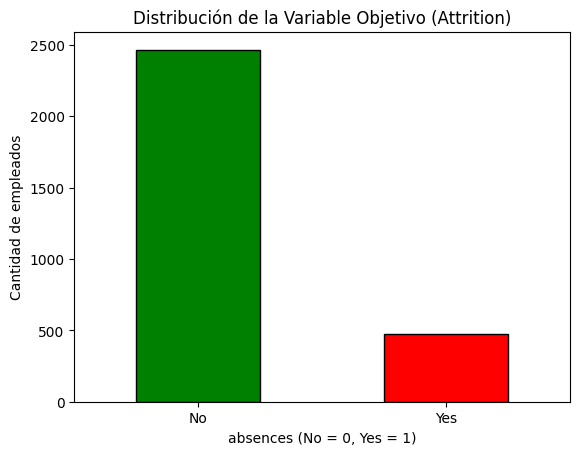

In [12]:
df_available["Attrition"].value_counts().plot(kind='bar', color=['green', 'red'], edgecolor="black")
plt.title("Distribución de la Variable Objetivo (Attrition)")
plt.ylabel("Cantidad de empleados")
plt.xlabel("absences (No = 0, Yes = 1)")
plt.xticks(rotation=0)
plt.show()

Conclusiones:

Se puede ver que hay un gran desbalanceo de clases de hasta 5 veces menos instancias para el valor "Yes"

---------------------------------------------------------------------

PUNTO 3: CROSS VALIDATION

1. Eliminación de datos irrelevantes

    Estas columnas son identificadores "EmployeeID" y valores constantes

In [13]:
# Eliminar columnas irrelevantes
drop_columns = ["EmployeeID", "Over18", "StandardHours", "EmployeeCount"]
df = df_available.drop(columns=drop_columns, errors='ignore')

2. Convertir todas las variables a tipo numérico y separar según características y variable objetivo (Attrition)

In [14]:
# Convertir variables categóricas a numéricas usando Label Encoding
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Guardar para futuras conversiones si es necesario

# Separar en características (X) y variable objetivo (y)
X = df.drop(columns=["Attrition"])
y = df["Attrition"]

3. Preprocesamiento de datos: detección de outliers y escalado

3.1. Seleccionando columnas numéricas

In [15]:
df = X

numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

3.2. Función para detectar outliers usando regla IQR

In [16]:
def porcentaje_outliers(col):
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    # Definir límites
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = ((col < lower_bound) | (col > upper_bound)).sum()
    return outlier_count / len(col)

3.3. Definiendo umbrales para la recomendación
    
- Si la asimentría es mayor a 1 o menor a -1 se considera alta asimetría
- Si más del 5% de las instancias son outliers

In [17]:
umbral_skew = 1.0
umbral_out = 0.05

print("Recomendación de transformación para cada columna numérica:")
print("-" * 70)

robust_columns = []
standard_columns = []

for col in numerical_cols:
    serie = df[col]
    skew = serie.skew()
    outlier_pct = porcentaje_outliers(serie)
    desc = serie.describe()
    
    print(f"\nColumna: {col}")
    print(f"  Media: {desc['mean']:.3f}, Std: {desc['std']:.3f}")
    print(f"  Mín: {desc['min']}, Máx: {desc['max']:.3f}")
    print(f"  Asimetría (skew): {skew:.3f}")
    print(f"  Porcentaje de outliers (IQR): {outlier_pct*100:.2f}%")
    
    # Lógica de recomendación
    if abs(skew) > umbral_skew or outlier_pct > umbral_out:
        robust_columns.append(col)
        print("  -> Sugerencia: La distribución es sesgada y/o presenta outliers; se recomienda normalización o escalado robusto.")
    else:
        standard_columns.append(col)
        print("  -> Sugerencia: Distribución aproximadamente normal; se recomienda estandarización con StandardScaler.")

Recomendación de transformación para cada columna numérica:
----------------------------------------------------------------------

Columna: hrs
  Media: 7.326, Std: 1.334
  Mín: 5.4168797411869445, Máx: 10.937
  Asimetría (skew): 0.859
  Porcentaje de outliers (IQR): 2.62%
  -> Sugerencia: Distribución aproximadamente normal; se recomienda estandarización con StandardScaler.

Columna: absences
  Media: 12.702, Std: 5.518
  Mín: 1.0, Máx: 24.000
  Asimetría (skew): 0.015
  Porcentaje de outliers (IQR): 0.00%
  -> Sugerencia: Distribución aproximadamente normal; se recomienda estandarización con StandardScaler.

Columna: JobInvolvement
  Media: 2.740, Std: 0.718
  Mín: 1.0, Máx: 4.000
  Asimetría (skew): -0.516
  Porcentaje de outliers (IQR): 0.00%
  -> Sugerencia: Distribución aproximadamente normal; se recomienda estandarización con StandardScaler.

Columna: PerformanceRating
  Media: 3.161, Std: 0.367
  Mín: 3.0, Máx: 4.000
  Asimetría (skew): 1.847
  Porcentaje de outliers (IQR): 16

3.4. Instanciación y aplicación de escaladores

In [18]:
robust_scaler = RobustScaler()
standard_scaler = StandardScaler()

# Aplicar las transformaciones de forma separada
X_transformed = X.copy()

if robust_columns:
    X_transformed[robust_columns] = robust_scaler.fit_transform(X[robust_columns])
if standard_columns:
    X_transformed[standard_columns] = standard_scaler.fit_transform(X[standard_columns])

4. Division de datos y configuración de Cross-Validation

    Se usa el parametro stratify para mantener la proporción de clases en Train y Test. Debido al desbalanceo de clases que se vio en el EDA.

In [19]:
# Dividir en Train (2/3) y Test (1/3)
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=1/3, random_state=3, stratify=y)

# Evaluación INNER: K-Fold Cross Validation (k=5)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

print("Datos preparados: Train (2/3), Test (1/3), y Cross-Validation lista.")


Datos preparados: Train (2/3), Test (1/3), y Cross-Validation lista.


5. Evaluación outer: Estimación de rendimiento con un modelo base

In [20]:
# Entrenar modelo base en Train
model = DecisionTreeClassifier(random_state=3)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=3)

In [21]:
# Predecir en el conjunto de Test (Outer Evaluation)
y_pred = model.predict(X_test)

In [22]:
# Cálculo de métricas
balanced_acc = balanced_accuracy_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

In [23]:
# Matriz de confusión para obtener TPR y TNR
conf_matrix = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

In [24]:
# True Positive Rate (TPR) y True Negative Rate (TNR)
TPR = tp / (tp + fn)
TNR = tn / (tn + fp)

# Mostrar resultados
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"True Positive Rate (TPR): {TPR:.4f}")
print(f"True Negative Rate (TNR): {TNR:.4f}")
print(f"Matriz de Confusión:\n{conf_matrix}")

Balanced Accuracy: 0.8580
Accuracy: 0.9204
True Positive Rate (TPR): 0.7658
True Negative Rate (TNR): 0.9501
Matriz de Confusión:
[[781  41]
 [ 37 121]]


La métrica de referencia para esta caso es Balanced Accuracy Score, ya que el dataset está desbalanceado.

Otras métricas que también se pueden ser útiles son:
- F1 Score
- AUC Score

5. HPO

Explicacion de los hiperparámetro modificados:

Criterion: Este hiperparámetro define la función de calidad de la división. 

En este caso se escogieron entre "gini" y "entropy".

- "gini": Es el índice de Gini, que mide la impureza de un nodo. Un valor de 0 indica que todas las muestras pertenecen a una sola clase.
- "entropy": Es la entropía, que mide la cantidad de información necesaria para clasificar una muestra. Un valor de 0 indica que todas las muestras pertenecen a una sola clase.

Max_depth: Define la profundidad máxima del árbol. Este hiperparámetro es fundamental cuando se trabaja con un conjunto de datos con alto como en este caso.

Min_samples_split: Es el número mínimo de muestras requeridas para dividir un nodo. Ajustar este parámetro ayuda a evitar divisiones muy específicas que pueden llevar a un sobreajuste.

Min_samples_leaf: Es el número mínimo de muestras requeridas para estar en un nodo hoja. La modificación de este parámetro ayuda a evitar que se produzcan hojas con muy pocas muestras, lo que puede llevar a un sobreajuste.

Max_features: Es el número máximo de características a considerar al buscar la mejor división. Como en este caso se cuenta con variables categóricas y numéricas, ajustar este parámetro se puede mejorar la precisión del modelo y reducir el riesgo de sobreajuste.

- "sqrt": Se considera la raíz cuadrada del número total de características. Este valor es útil para reducir la varianza y mejorar la precisión del modelo.
- "log2": Se considera el logaritmo en base 2 del número total de características. Este valor es útil para reducir la varianza y mejorar la precisión del modelo.
- None: Se considera todas las características. Este valor puede llevar a un sobreajuste si no se tiene cuidado.

Class_weight: Como se vio en el apartado de EDA, la variable objetivo con la que se trabaja está desbalanceada (aproximadamente 84% "No" y 16% "Yes"). Por lo que se le asigna un peso mayor a la clase minoritaria para ayudar al modelo a aprender de manera más efectiva. 

- "balanced": Se ajusta automáticamente el peso de cada clase inversamente proporcional a su frecuencia en el conjunto de datos.
- "balanced_subsample": Se ajusta automáticamente el peso de cada clase inversamente proporcional a su frecuencia en el conjunto de datos, pero solo se considera una muestra aleatoria de los datos.
- None: No se ajusta el peso de las clases. Este valor puede llevar a un sobreajuste si no se tiene cuidado.

In [25]:
# Definir el espacio de hiperparámetros a optimizar
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

# Usar el mismo kfold definido para la evaluación inner
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=3),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=kfold,
    n_jobs=-1
)

# Ajustar en el conjunto de entrenamiento
grid_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros y la métrica de inner evaluation
print("Mejores hiperparámetros:", grid_search.best_params_)
print("Puntuación inner (Balanced Accuracy):", grid_search.best_score_)


Mejores hiperparámetros: {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Puntuación inner (Balanced Accuracy): 0.8076136239610875


--------------------------------------------------------------------------------------

PUNTO 4: MÉTODOS BÁSICOS (KNN y Árboles de decisión)

1. Escalar e imputar usando KNN como referencia

In [26]:
scalers = {
    "StandardScaler": StandardScaler(),
    "MinMaxScaler": MinMaxScaler(),
    "RobustScaler": RobustScaler()
}

imputers = {
    "Mean": SimpleImputer(strategy="mean"),
    "Median": SimpleImputer(strategy="median")
}

2. Evaluando con KNN y árboles de decisión

In [27]:
kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)
best_score = 0
best_scaler = None
best_imputer = None
best_score_tree = 0
best_scaler_tree = None
best_imputer_tree = None

for scaler_name, scaler in scalers.items():
    for imputer_name, imputer in imputers.items():
        X_train_imputed = imputer.fit_transform(X_train)
        X_train_scaled = scaler.fit_transform(X_train_imputed)
        
        knn = KNeighborsClassifier(n_neighbors=5)
        score = np.mean(cross_val_score(knn, X_train_scaled, y_train, cv=kfold, scoring="balanced_accuracy"))
        
        print("---------------KNN---------------")
        print(f"Scaler: {scaler_name}\nImputer: {imputer_name}\nScore: {score:.4f}")
        
        if score > best_score:
            best_score = score
            best_scaler = scaler
            best_imputer = imputer
        # Para arboles de decisión
        tree_= DecisionTreeClassifier(random_state=3)
        score_tree = np.mean(cross_val_score(tree_, X_train_scaled, y_train, cv=kfold, scoring="balanced_accuracy"))
        
        print("----------Decision Tree----------")
        print(f"Scaler: {scaler_name}\nImputer: {imputer_name}\nScore (Tree): {score_tree:.4f}")
        
        if score_tree > best_score_tree:
            best_score_tree = score_tree
            best_scaler_tree = scaler
            best_imputer_tree = imputer



---------------KNN---------------
Scaler: StandardScaler
Imputer: Mean
Score: 0.5928
----------Decision Tree----------
Scaler: StandardScaler
Imputer: Mean
Score (Tree): 0.7788
---------------KNN---------------
Scaler: StandardScaler
Imputer: Median
Score: 0.5928
----------Decision Tree----------
Scaler: StandardScaler
Imputer: Median
Score (Tree): 0.7806
---------------KNN---------------
Scaler: MinMaxScaler
Imputer: Mean
Score: 0.5912
----------Decision Tree----------
Scaler: MinMaxScaler
Imputer: Mean
Score (Tree): 0.7793
---------------KNN---------------
Scaler: MinMaxScaler
Imputer: Median
Score: 0.5899
----------Decision Tree----------
Scaler: MinMaxScaler
Imputer: Median
Score (Tree): 0.7805
---------------KNN---------------
Scaler: RobustScaler
Imputer: Mean
Score: 0.5968
----------Decision Tree----------
Scaler: RobustScaler
Imputer: Mean
Score (Tree): 0.7788
---------------KNN---------------
Scaler: RobustScaler
Imputer: Median
Score: 0.5962
----------Decision Tree----------


In [28]:
print("\nMejor combinación de scaler e imputer para KNN:")
print(f"\tScaler: {best_scaler.__class__.__name__}\n\tImputer: {best_imputer.strategy}\n\tScore: {best_score:.4f}")
print("\nMejor combinación de scaler e imputer para Decision Tree:")
print(f"\tScaler: {best_scaler_tree.__class__.__name__}\n\tImputer: {best_imputer_tree.strategy}\n\tScore: {best_score_tree:.4f}")


Mejor combinación de scaler e imputer para KNN:
	Scaler: RobustScaler
	Imputer: mean
	Score: 0.5968

Mejor combinación de scaler e imputer para Decision Tree:
	Scaler: StandardScaler
	Imputer: median
	Score: 0.7806


a. Hiperparámetros por omisión

In [29]:
X_train_imputed = best_imputer.fit_transform(X_train)
X_test_imputed = best_imputer.transform(X_test)
X_train_scaled = best_scaler.fit_transform(X_train_imputed)
X_test_scaled = best_scaler.transform(X_test_imputed)

knn_omision = KNeighborsClassifier()
start_time = time.time()
knn_omision.fit(X_train_scaled, y_train)
end_time = time.time()
knn_omision_pred = knn_omision.predict(X_test_scaled)
knn_omision_balanced_acc = balanced_accuracy_score(y_test, knn_omision_pred)
knn_omision_time = end_time - start_time
print("KNN con imputación de valores faltantes:")
print(f"  Balanced Accuracy: {knn_omision_balanced_acc:.4f}")
print(f"  Tiempo de entrenamiento: {knn_omision_time:.4f} segundos")

KNN con imputación de valores faltantes:
  Balanced Accuracy: 0.6222
  Tiempo de entrenamiento: 0.0010 segundos


In [30]:
# Decision Tree
X_train_imputed_tree = best_imputer_tree.fit_transform(X_train)
X_test_imputed_tree = best_imputer_tree.transform(X_test)
X_train_scaled_tree = best_scaler_tree.fit_transform(X_train_imputed_tree)
X_test_scaled_tree = best_scaler_tree.transform(X_test_imputed_tree)

dt_omision = DecisionTreeClassifier()
start_time = time.time()
dt_omision.fit(X_train_scaled_tree, y_train)
end_time = time.time()
dt_omision_pred = dt_omision.predict(X_test_scaled_tree)
dt_omision_balanced_acc = balanced_accuracy_score(y_test, dt_omision_pred)
dt_omision_time = end_time - start_time
print("Decision Tree sin imputación y escalado:")
print(f"  Balanced Accuracy: {dt_omision_balanced_acc:.4f}")
print(f"  Tiempo de entrenamiento: {dt_omision_time:.4f} segundos")

Decision Tree sin imputación y escalado:
  Balanced Accuracy: 0.8586
  Tiempo de entrenamiento: 0.0199 segundos


b. Ajuste de hiperparámetros (HPO) usando GridSearchCV

Explicación de los hiperparámetros modificados en el modelo KNN:

n_neighbors: Este hiperparámetro define el número de vecinos a considerar al clasificar una muestra. Un valor bajo puede llevar a un sobreajuste, mientras que un valor alto puede llevar a un subajuste

weights: Permite elegir cómo se ponderan los vecinos al hacer la predicción. 

- "uniform": Todos los vecinos tienen el mismo peso.
- "distance": Los vecinos más cercanos tienen un mayor peso en la predicción.

metrics: Este hiperparámetro define la métrica de distancia a utilizar. 

- "euclidean": La distancia euclidiana, que es la distancia "normal" entre dos puntos en un espacio euclidiano.
- "manhattan": La distancia de Manhattan, que es la suma de las diferencias absolutas entre las coordenadas de los puntos.
- "minkowski": La distancia de Minkowski, que es una generalización de las distancias euclidiana y de Manhattan.


Explicación de los hiperparámetros modificados en el modelo de Árboles de decisión:

Se han modificado los mismos hiperparámetros que en el punto 3.

NOTA: 

Además de los hiperparámetros modificados, se ha usado RepeatedStratifiedKFold para la validación cruzada. 

Este método es útil para obtener una estimación más robusta del rendimiento del modelo, ya que realiza múltiples divisiones de los datos y promedia los resultados. Esto ayuda a reducir la varianza en la estimación del rendimiento del modelo y proporciona una mejor idea de cómo se comportará el modelo en datos no vistos.

In [31]:
tree_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

knn_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# Definiendo la validación cruzada repetida
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)

# Optimización con GridSearchCV 
knn_grid = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_params,
    scoring='balanced_accuracy',
    cv=rskf,
    n_jobs=-1
)

tree_grid = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=3),
    param_grid=tree_params,
    scoring='balanced_accuracy',
    cv=rskf,
    n_jobs=-1
)

# Entrenamos GridSearchCV en el conjunto de entrenamiento escalado
start_time_knn = time.time()
knn_grid.fit(X_train_scaled, y_train)
end_time_knn = time.time()
knn_time = end_time_knn - start_time_knn

start_time_tree = time.time()
tree_grid.fit(X_train_scaled_tree, y_train)
end_time_tree = time.time()
tree_time = end_time_tree - start_time_tree

# Mostrar el mejor resultado obtenido para cada modelo
print("KNeighborsClassifier:")
print(f"\tMejor KNN: {knn_grid.best_params_}\n\tBalanced Accuracy: {knn_grid.best_score_:.4f}")
print(f"\tTiempo de entrenamiento: {knn_time:.4f} segundos")

num_iterations = len(knn_grid.cv_results_['params'])
print(f"\tTiempo medio por iteración: {knn_time / num_iterations:.4f} segundos")

print("\nDecisionTreeClassifier:")
print(f"\tMejor Árbol: {tree_grid.best_params_}\n\tBalanced Accuracy: {tree_grid.best_score_:.4f}")
print(f"\tTiempo de entrenamiento: {tree_time:.4f} segundos")

num_iterations_tree = len(tree_grid.cv_results_['params'])
print(f"\tTiempo medio por iteración: {tree_time / num_iterations_tree:.4f} segundos")


KNeighborsClassifier:
	Mejor KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
	Balanced Accuracy: 0.8164
	Tiempo de entrenamiento: 2.5146 segundos
	Tiempo medio por iteración: 0.1572 segundos

DecisionTreeClassifier:
	Mejor Árbol: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
	Balanced Accuracy: 0.7827
	Tiempo de entrenamiento: 24.5551 segundos
	Tiempo medio por iteración: 0.0568 segundos


Conclusión:
Se puede observar que el coste computacional medido como tiempo medio de iteración es mucho mayor en el modelo KNN que en el de Árboles de decisión.

c. Plots de los hiperparámetros 

Primero se convierten los resultados a un dataframe y se convierten los resultados a string para poder graficar los resultados de los hiperparámetros.

In [32]:
tree_results = pd.DataFrame(tree_grid.cv_results_)
knn_results = pd.DataFrame(knn_grid.cv_results_)

# Árbol de decisión
tree_results['param_max_depth_str'] = tree_results['param_max_depth'].astype(str)
tree_results['param_min_samples_split_str'] = tree_results['param_min_samples_split'].astype(str)
tree_results['param_min_samples_leaf_str'] = tree_results['param_min_samples_leaf'].astype(str)
tree_results['param_criterion_str'] = tree_results['param_criterion'].astype(str)
tree_results['param_max_features_str'] = tree_results['param_max_features'].astype(str)
tree_results['param_class_weight_str'] = tree_results['param_class_weight'].astype(str)
# KNN
knn_results['param_n_neighbors_str'] = knn_results['param_n_neighbors'].astype(str)
knn_results['param_weights_str'] = knn_results['param_weights'].astype(str)
knn_results['param_metric_str'] = knn_results['param_metric'].astype(str)

Comparación de cuál es el mejor modelo entre KNN y Árboles de decisión

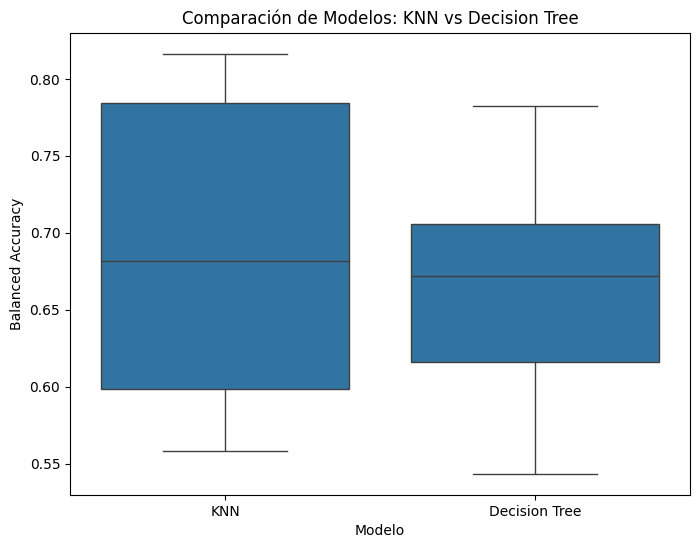

In [33]:
knn_results['Modelo'] = 'KNN'
tree_results['Modelo'] = 'Decision Tree'

combined_results = pd.concat([knn_results[['mean_test_score', 'Modelo']], tree_results[['mean_test_score', 'Modelo']]])

combined_results.rename(columns={'mean_test_score': 'Balanced Accuracy'}, inplace=True)

# Genera ndo el gráfico de boxplots
plt.figure(figsize=(8, 6))
sns.boxplot(x='Modelo', y='Balanced Accuracy', data=combined_results)
plt.title('Comparación de Modelos: KNN vs Decision Tree')
plt.xlabel('Modelo')
plt.ylabel('Balanced Accuracy')
plt.show()


Conclusiones:

Pese a que el mejor modelo de KNN era ligeramente superior al de Árboles de decisión, el coste computacional es mucho mayor en el modelo KNN. Además este gráfico de caja y bigote muestra que el modelo de KNN tiene una varianza mucho mayor que el de Árboles de decisión. Por lo que se puede concluir que el modelo de Árboles de decisión es más robusto y eficiente.

Plots de los hiperparámetros para árboles de decisión:

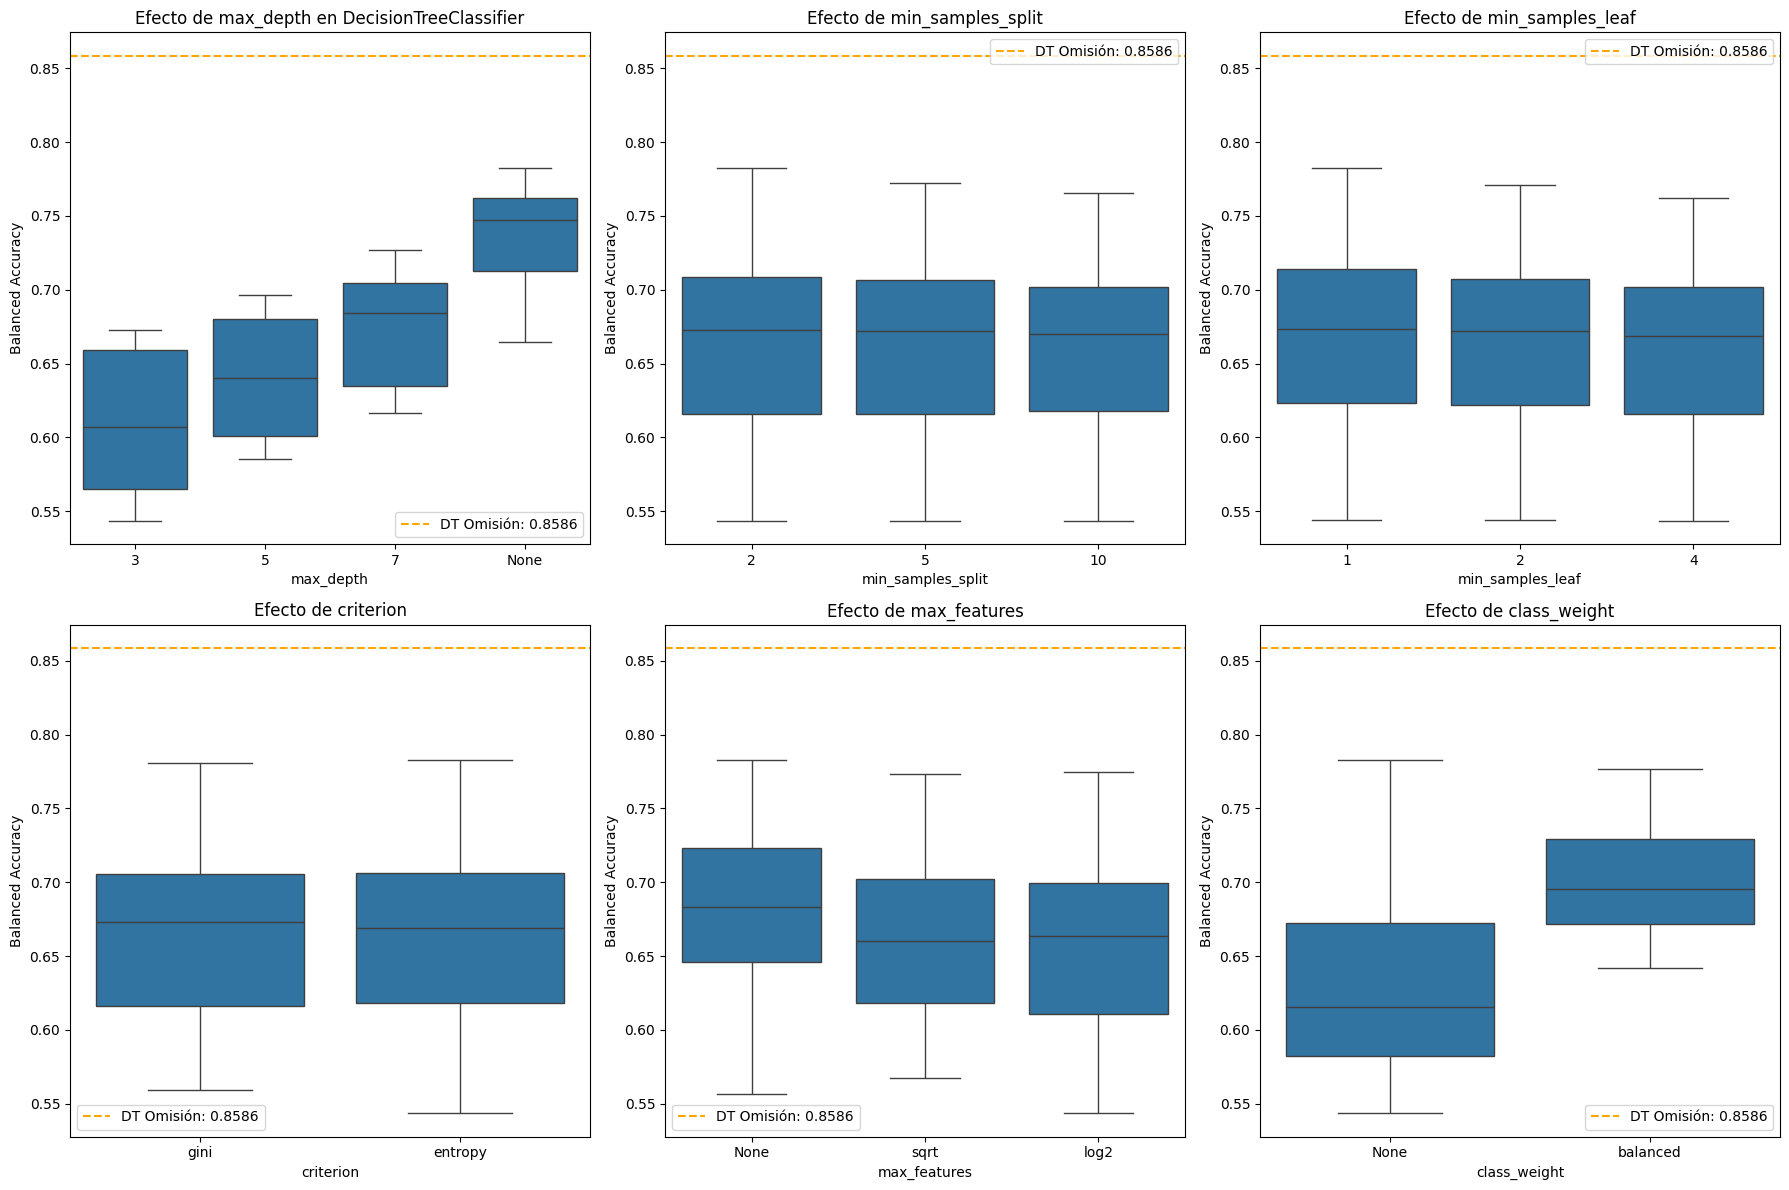

In [34]:
plt.figure(figsize=(18, 12))

# max_depth
ax1 = plt.subplot(2, 3, 1)
sns.boxplot(x='param_max_depth_str', y='mean_test_score', data=tree_results, ax=ax1)
ax1.axhline(y=dt_omision_balanced_acc, color='orange', linestyle='--', 
            label=f"DT Omisión: {dt_omision_balanced_acc:.4f}")
ax1.set_title('Efecto de max_depth en DecisionTreeClassifier')
ax1.set_xlabel('max_depth')
ax1.set_ylabel('Balanced Accuracy')
ax1.legend()

# min_samples_split
ax2 = plt.subplot(2, 3, 2)
sns.boxplot(x='param_min_samples_split_str', y='mean_test_score', data=tree_results, ax=ax2)
ax2.axhline(y=dt_omision_balanced_acc, color='orange', linestyle='--', 
            label=f"DT Omisión: {dt_omision_balanced_acc:.4f}")
ax2.set_title('Efecto de min_samples_split')
ax2.set_xlabel('min_samples_split')
ax2.set_ylabel('Balanced Accuracy')
ax2.legend()

# min_samples_leaf
ax3 = plt.subplot(2, 3, 3)
sns.boxplot(x='param_min_samples_leaf_str', y='mean_test_score', data=tree_results, ax=ax3)
ax3.axhline(y=dt_omision_balanced_acc, color='orange', linestyle='--', 
            label=f"DT Omisión: {dt_omision_balanced_acc:.4f}")
ax3.set_title('Efecto de min_samples_leaf')
ax3.set_xlabel('min_samples_leaf')
ax3.set_ylabel('Balanced Accuracy')
ax3.legend()

# criterion
ax4 = plt.subplot(2, 3, 4)
sns.boxplot(x='param_criterion_str', y='mean_test_score', data=tree_results, ax=ax4)
ax4.axhline(y=dt_omision_balanced_acc, color='orange', linestyle='--', 
            label=f"DT Omisión: {dt_omision_balanced_acc:.4f}")
ax4.set_title('Efecto de criterion')
ax4.set_xlabel('criterion')
ax4.set_ylabel('Balanced Accuracy')
ax4.legend()

# max_features
ax5 = plt.subplot(2, 3, 5)
sns.boxplot(x='param_max_features_str', y='mean_test_score', data=tree_results, ax=ax5)
ax5.axhline(y=dt_omision_balanced_acc, color='orange', linestyle='--', 
            label=f"DT Omisión: {dt_omision_balanced_acc:.4f}")
ax5.set_title('Efecto de max_features')
ax5.set_xlabel('max_features')
ax5.set_ylabel('Balanced Accuracy')
ax5.legend()

# class_weight
ax6 = plt.subplot(2, 3, 6)
sns.boxplot(x='param_class_weight_str', y='mean_test_score', data=tree_results, ax=ax6)
ax6.axhline(y=dt_omision_balanced_acc, color='orange', linestyle='--', 
            label=f"DT Omisión: {dt_omision_balanced_acc:.4f}")
ax6.set_title('Efecto de class_weight')
ax6.set_xlabel('class_weight')
ax6.set_ylabel('Balanced Accuracy')
ax6.legend()

plt.tight_layout()
plt.show()

Interpretación de los resultados:

- Max_depth: Se aprecia que a medida que se aumentan el número de profundidad del árbol, se aumenta la precisión balanceada. Es cierto que un numero muy alto puede inducir a sobreajuste, y a la poca capacidad de generalización. Sin embargo, en este caso parece razonable que al tener más de 20 atributos y no ser un caso de estudio trivial, la complejidad optima del árbol pueda ser mayor. En este anexo, se estudia mas en profundidad el comportamiento de este parametro.

- Min_samples_split: No hay una diferencia significativa entre 2, 5 y 10. Pero se puede observar que a medida que aumenta el valor de min_samples_split, la mediana y el rango de variación aumentan. Esto indica que el modelo está aprendiendo patrones más generales y no se está sobreajustando a los datos de entrenamiento.

- Min_samples_leaf: Se observa un fenómeno similar al de simples_split, solo que en este caso si hay una ligera tendencia a la baja en la precisión y también una ligera reducción de la dispersión. En este caso, al igual que el anterior puede tener sentido dejarlo en los valores mas altos debido al riesgo de sobreajuste, ya que una sola instancia para validar un nodo hoja no es propio de un modelo que aspira a generalizar correctamente. 

- Criterion: Las medianas son bastante similares. Es frecuente que Gini y Entropy no difieran mucho en la práctica, aunque uno de ellos puede presentar un leve incremento en la mediana. En este caso en el que diferencias son prácticamente, Gini suele ser un poco más rápido computacionalmente, por lo que sería el valor óptimo para este parámetro

- Max_features: Se observa que la precisión mediana es superior para el caso donde todos los atributos son considerados en el Split en lugar de reducirlo en orden de la raíz o el log2. En nuestro caso serían 5 y 4 (por redondeo) atributos a considerar en cada Split. Limitar el número de variables en cada Split parece ser la decisión acertada pese a la menor precisión media y mediana, ya que el riesgo de sobreajuste del modelo es alto mientras que en especial para el caso de la raíz la dispersión de precisiones disminuye significativamente, lo que hace pensar que es el valor optimo para este parámetro.

- Class_weight: En este parámetro parece claro que su media y su rango intercuartílico, es superior a no tener la ponderación por clase numerosa. Además de respaldarse con este aplastante dato, ya se vio en el análisis exploratorio de datos que se tenía una variable de salida muy desbalanceada lo que hace prácticamente obligado el uso de este parámetro para el correcto aprendizaje del modelo para la tarea que se presenta.

Comparando los resultados contra el modelo por omisión se puede observar que casi ninguna configuración de hiperparámetros es mejor que el modelo por omisión. Sin embargo, la configuración por omisión es muy propensa a sobreajuste ya que usa valores que se han visto en el análisis del párrafo anterior que tienden a generalizar muy poco. Es claro ver que todas las configuraciones consiguen superar al modelo trivial de forma holgada.

En conclusión, pese a la buena métrica de precisión balanceada, el modelo por omisión no es el mejor modelo para este caso. Se recomienda usar un modelo con una configuración de hiperparámetros que evite el sobreajuste y que tenga una buena capacidad de generalización.

ANEXO

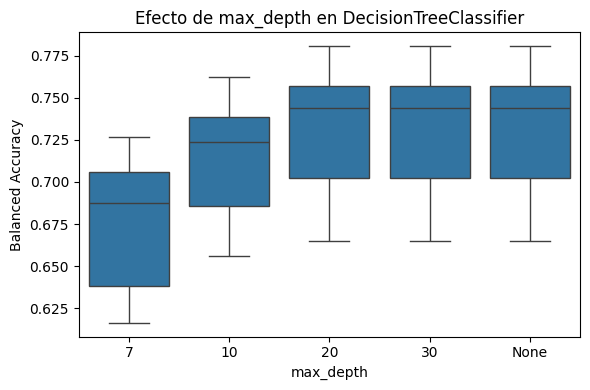

In [35]:
tree_params_v2 = {
    'criterion': ['gini'],
    'max_depth': [7, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42)

# Optimización con GridSearchCV para DecisionTreeClassifier
tree_grid_v2= GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=3),
    param_grid=tree_params_v2,
    scoring='balanced_accuracy',
    cv=rskf,
    n_jobs=-1
)

# Entrenamos GridSearchCV en el conjunto de entrenamiento escalado
tree_grid_v2.fit(X_train_scaled_tree, y_train)

tree_results_v2 = pd.DataFrame(tree_grid_v2.cv_results_)
# Árbol de decisión
tree_results_v2['param_max_depth_str'] = tree_results_v2['param_max_depth'].astype(str)
# max_depth
plt.figure(figsize=(6, 4))
sns.boxplot(x='param_max_depth_str', y='mean_test_score', data=tree_results_v2)
plt.title('Efecto de max_depth en DecisionTreeClassifier')
plt.xlabel('max_depth')
plt.ylabel('Balanced Accuracy')
plt.tight_layout()
plt.show()

CONCLISIONES DEL ANEXO

Se puede observar el parámetro max_depth sigue aumentando a medida que se aumenta el número de profundidad del árbol, pero la precisión balanceada no mejora a partir de cierto punto, ubicado entre 10 y 20. Esto indica que a partir de estos valores el modelo deja de aprender patrones más generales y muy posiblemente se está sobreajustando a los datos de entrenamiento.

Como valor óptimo se considerará 10

Plots de los hiperparámetros para el modelo KNN:

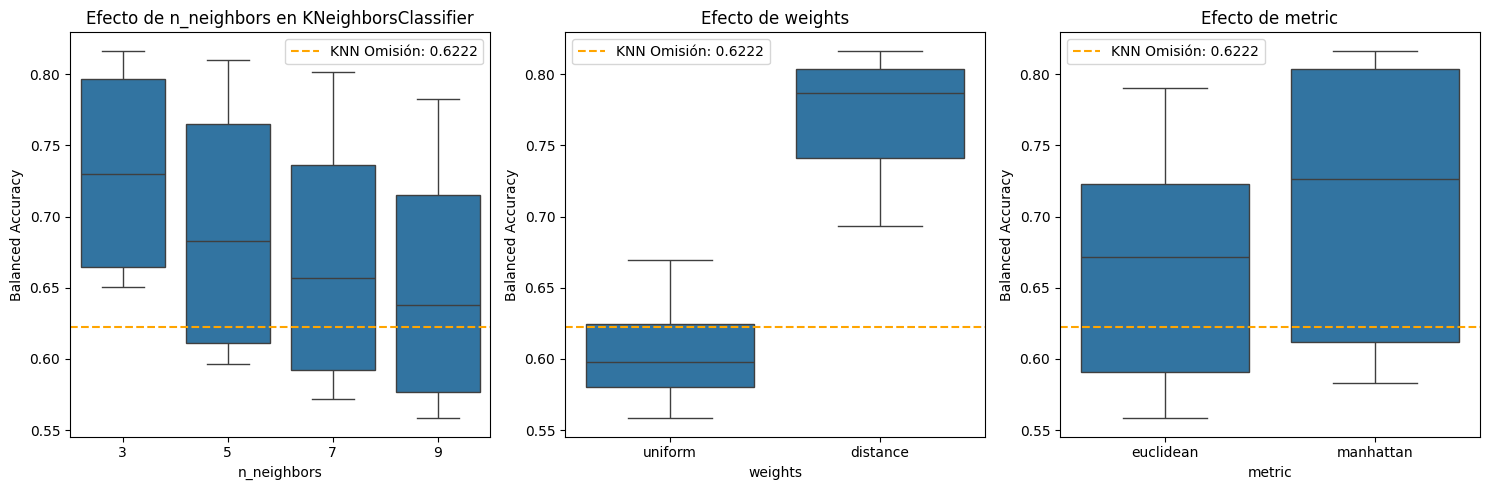

In [36]:
plt.figure(figsize=(15, 5))

# n_neighbors
ax1 = plt.subplot(1, 3, 1)
sns.boxplot(x='param_n_neighbors_str', y='mean_test_score', data=knn_results, ax=ax1)
ax1.axhline(y=knn_omision_balanced_acc, color='orange', linestyle='--', 
            label=f"KNN Omisión: {knn_omision_balanced_acc:.4f}")
ax1.set_title('Efecto de n_neighbors en KNeighborsClassifier')
ax1.set_xlabel('n_neighbors')
ax1.set_ylabel('Balanced Accuracy')
ax1.legend()

# weights
ax2 = plt.subplot(1, 3, 2)
sns.boxplot(x='param_weights_str', y='mean_test_score', data=knn_results, ax=ax2)
ax2.axhline(y=knn_omision_balanced_acc, color='orange', linestyle='--', 
            label=f"KNN Omisión: {knn_omision_balanced_acc:.4f}")
ax2.set_title('Efecto de weights')
ax2.set_xlabel('weights')
ax2.set_ylabel('Balanced Accuracy')
ax2.legend()

# metric
ax3 = plt.subplot(1, 3, 3)
sns.boxplot(x='param_metric_str', y='mean_test_score', data=knn_results, ax=ax3)
ax3.axhline(y=knn_omision_balanced_acc, color='orange', linestyle='--', 
            label=f"KNN Omisión: {knn_omision_balanced_acc:.4f}")
ax3.set_title('Efecto de metric')
ax3.set_xlabel('metric')
ax3.set_ylabel('Balanced Accuracy')
ax3.legend()

plt.tight_layout()
plt.show()

Interpretación de los resultados:

- n_neighbors: Se aprecia que a medida que se aumenta el numero de vecinos tanto la mediana como las cajas van a la baja. Es cierto que con 3 vecinos se obtienen los mejores resultados con la mejor de las varianzas. Sin embargo, esto puede estar influenciado por un mas que posible sobreajuste. De la misma manera el valor de 9 parece estar muy alejado de una precisión balanceada aceptable, haciéndolo ligeramente mejor que un modelo trivial (0.5 de precisión balanceada). Por lo que en este parámetro el balance deseado entre sobre y subajuste parece estar en los valores centrales testeados (5 y 7 vecinos).

- weights: En este parámetro parece clara que la mejoría que se aprecia al usar la distancia como peso de la influencia de cada vecino (a menor distancia mayor peso). Sin embargo, con uniform se pierde esa información y se le da el mismo peso a todos por lo que a la hora de hacer el perfilado de las clases aquellos vecinos menos representativos pueden introducir ruido en las predicciones.

- metric: Se observa que, en general, manhattan obtiene una Balanced Accuracy ligeramente mayor (o similar) que euclidean, con diferencias que pueden no ser muy grandes pero sí consistentes. Desde el punto de vista de la naturaleza de los datos la distancia Manhattan al medir la distancia como la suma de las diferencias absolutas en cada dimensión, se debería comportar mejor con escalas y distribuciones variables en cada atributo.  En el análisis exploratorio de los datos se veían un número significativo de variables presentaban outliers o distribuciones sesgadas, por lo que la distancia Manhattan puede resultar más robusta para este caso de estudio.

En cuanto a la comparación de precisión balanceada contra el modelo por omision (línea discontinua naranja)se puede observar que ciertas configuraciones proporcionan mejores resultados y por ende tambien serían mejores que el modelo trivial. 

-------------------------------------------

PUNTO 5: MÉTODOS AVANZADOS (MÉTODOS LINEALES Y SVMs)

1. Conjunto de entrenamiento y prueba

No se van a utilizar escaladores ni imputadores en este apartado. Lo que se ha entendido es que se quiere explorar el rendimiento de estos modelos sin ningún tipo de preprocesado. Por esta razón se han eliminado filas con valores nulos

In [37]:
X_y = pd.concat([X, y], axis=1).dropna()
X = X_y.drop(columns=y.name)
y = X_y[y.name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=3, stratify=y)

2. Modelos lineales

Sin regularización

Se utilizará LogisticRegression con penanlty "l2" con un valor muy alto de C (1e10) para que no se aplique regularización.

Como se pude ver, al ejecutar la celda sale un Warning indicando que el optimizador por defecto LogisticLBFGS no logró minimizar la función de costo. 


Esto se debe a que los datos no están escalados ni los parámetros de optimización ajustados(hecho a propósito para ver el rendimiento de este modelo sin ningún tipo de preprocesado).

Con regularización L1 (penalty='l1')

Cuando C es mayor en L1, hay menos regulacion y cuando C es menor hay más regularización. Por lo que se ha usado un valor de 0.1 para que haya una regularización moderada.

In [38]:
param_grid_lineal = {
    'penalty': ['l1'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000],
    'class_weight': [None, 'balanced'],
}
grid_search_lineal = GridSearchCV(
    estimator = LogisticRegression(random_state=3),
    param_grid = param_grid_lineal,
    scoring = 'balanced_accuracy',
    # cv=kfold,
    cv = 3,
    n_jobs = -1
)

start_time = time.time()
grid_search_lineal.fit(X_train, y_train)
end_time = time.time()
tiempo_grid_search_lineal = end_time - start_time

mejor_modelo_lineal = grid_search_lineal.best_estimator_
mejor_score_lineal = grid_search_lineal.best_score_
mejor_params_lineal = grid_search_lineal.best_params_
y_pred_lineal = mejor_modelo_lineal.predict(X_test)
balanced_acc_lineal = balanced_accuracy_score(y_test, y_pred_lineal)
print("Mejor Modelo Lineal con Regularización L1:")
print(f"  Balanced Accuracy: {balanced_acc_lineal:.4f}")
print(f"  Mejor Parámetros: {mejor_params_lineal}") 
print(f"  Tiempo de entrenamiento: {tiempo_grid_search_lineal:.4f} segundos")

Mejor Modelo Lineal con Regularización L1:
  Balanced Accuracy: 0.7060
  Mejor Parámetros: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
  Tiempo de entrenamiento: 2.6888 segundos


2. Modelos SVMs

Sin regularización

In [39]:
start_time = time.time()
modelo_svm = SVC()
modelo_svm.fit(X_train, y_train)
end_time = time.time()
tiempo_modelo_svm = end_time - start_time

y_pred_svm = modelo_svm.predict(X_test)
balanced_acc_svm = balanced_accuracy_score(y_test, y_pred_svm)
print("Modelo SVM:")
print(f"  Balanced Accuracy: {balanced_acc_svm:.4f}")
print(f"  Tiempo de entrenamiento: {tiempo_modelo_svm:.4f} segundos")

Modelo SVM:
  Balanced Accuracy: 0.5000
  Tiempo de entrenamiento: 0.0382 segundos


Con ajuste de hiperparámetros

Se han modificado los siguientes hiperparámetros:
- C: Este hiperparámetro controla la penalización por error en el modelo. Un valor alto de C significa que el modelo se centrará más en clasificar correctamente los puntos de entrenamiento, lo que puede llevar a un sobreajuste. Un valor bajo de C significa que el modelo será más flexible y tolerará más errores, lo que puede llevar a un subajuste.

- kernel: Este hiperparámetro define el tipo de kernel a utilizar. En este caso se han usado los siguientes:
    - "linear": Un kernel lineal, que es útil para datos linealmente separables.
    - "rbf": Un kernel radial, que es útil para datos no linealmente separables.

In [40]:
print("¿Hay NaNs en X_train?", X_train.isnull().values.any())

¿Hay NaNs en X_train? False


In [41]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

X_train shape: (1915, 26)
y_train shape: (1915,)


In [ ]:
from sklearn.calibration import LinearSVC
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    # 'kernel': ['linear']
}
grid_search_svm = GridSearchCV(
    estimator = LinearSVC(random_state=3, max_iter=5000),
    param_grid = param_grid_svm,
    scoring = 'balanced_accuracy',
    cv = 3,
    n_jobs = 1
)
start_time = time.time()
grid_search_svm.fit(X_train, y_train)
end_time = time.time()
tiempo_grid_search_svm = end_time - start_time

mejor_modelo_svm = grid_search_svm.best_estimator_
mejor_score_svm = grid_search_svm.best_score_
mejor_params_svm = grid_search_svm.best_params_
y_pred_svm = mejor_modelo_svm.predict(X_test)
balanced_acc_svm = balanced_accuracy_score(y_test, y_pred_svm)
print("Mejor Modelo SVM:")
print(f"  Balanced Accuracy: {balanced_acc_svm:.4f}")
print(f"  Mejor Parámetros: {mejor_params_svm}")
print(f"  Tiempo de entrenamiento: {tiempo_grid_search_svm:.4f} segundos")

Mejor Modelo SVM:
  Balanced Accuracy: 0.5000
  Mejor Parámetros: {'C': 0.1}
  Tiempo de entrenamiento: 0.0779 segundos


3. Importancia de los atributos

Importancia de los atributos en el Modelo Lineal L1 ajustado


🔹 Importancia de los atributos según el modelo lineal (L1):
hrs: 0.4137
absences: 0.0140
JobInvolvement: -0.0219
EnvironmentSatisfaction: -0.2979
JobSatisfaction: -0.2781
WorkLifeBalance: -0.2106
Age: -0.0218
Department: -0.0011
DistanceFromHome: 0.0067
EducationField: -0.0752
JobLevel: -0.1116
JobRole: -0.0085
MaritalStatus: 0.5621
NumCompaniesWorked: 0.1127
PercentSalaryHike: 0.0065
TotalWorkingYears: -0.0726
TrainingTimesLastYear: -0.1406
YearsAtCompany: 0.0672
YearsSinceLastPromotion: 0.1108
YearsWithCurrManager: -0.1782


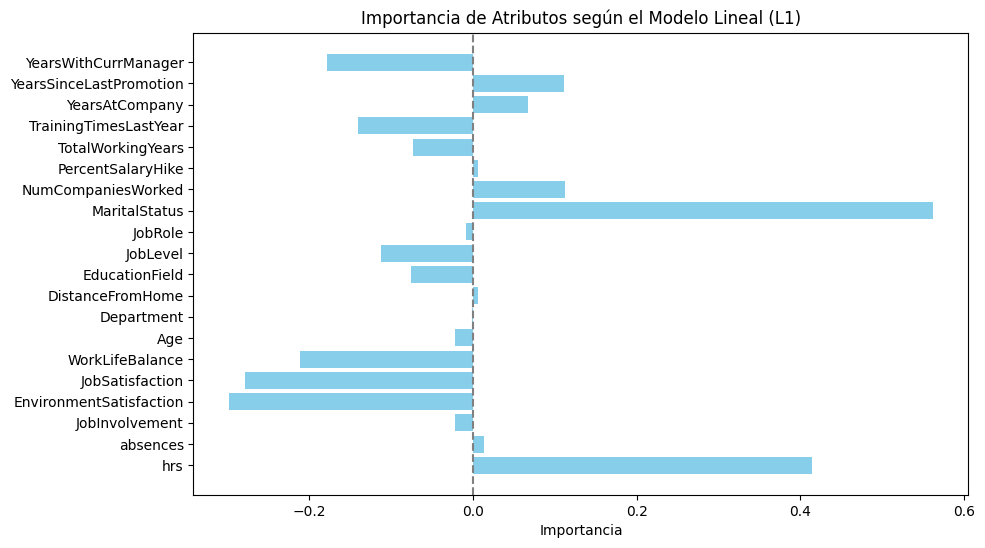

In [58]:
importancia_lineal = mejor_modelo_lineal.coef_[0]
atributos_relevantes = X_train.columns[np.abs(importancia_lineal) > 1e-5]


print("\n🔹 Importancia de los atributos según el modelo lineal (L1):")
for atrr, val in zip(atributos_relevantes, importancia_lineal[np.abs(importancia_lineal) > 1e-5]):
    print(f"{atrr}: {val:.4f}")

plt.figure(figsize=(10, 6))
plt.barh(atributos_relevantes, importancia_lineal[np.abs(importancia_lineal) > 1e-5], color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de Atributos según el Modelo Lineal (L1)')
plt.axvline(x=0, color='gray', linestyle='--')
plt.show()

Importancia de los atributos en el Modelo SVM ajustado

Se usará Permutation Feature Importance para calcular la importancia de los atributos. Este método consiste en permutar los valores de una característica y medir el impacto en la precisión del modelo. Si la precisión disminuye significativamente, significa que la característica es importante para el modelo. Si la precisión no cambia mucho, significa que la característica no es tan importante.


Importancia de los atributos según el modelo SVM:
                Atributo  Importancia
7                    Age     0.009622
25  YearsWithCurrManager     0.007798
21     TotalWorkingYears     0.007250
1               absences     0.006865
23        YearsAtCompany     0.006839


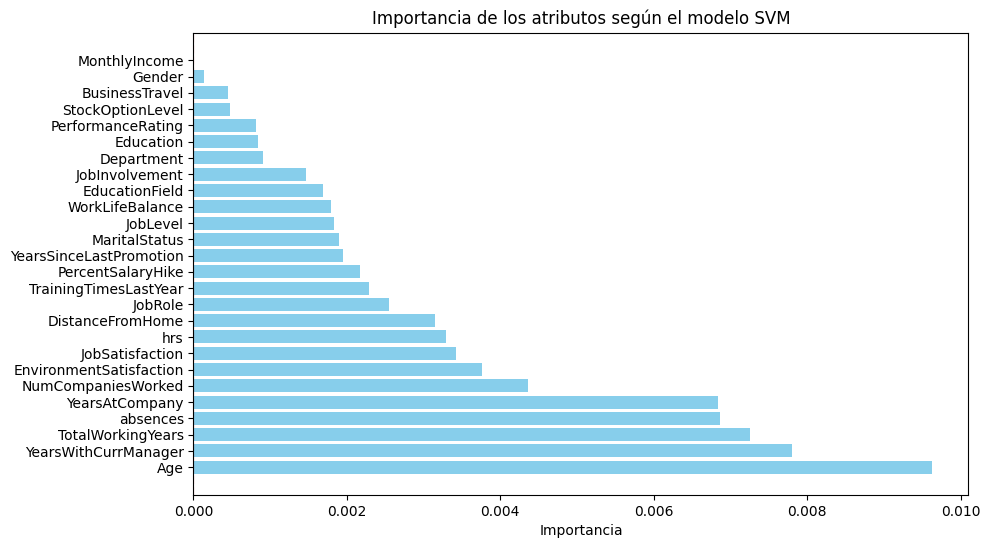

In [53]:
importancia = abs(mejor_modelo_svm.coef_[0])
atributos = X_train.columns

importancia_df = pd.DataFrame({
    'Atributo': atributos,
    'Importancia': importancia
}).sort_values(by='Importancia', ascending=False)

print("\nImportancia de los atributos según el modelo SVM:")
print(importancia_df.head())

plt.figure(figsize=(10, 6))
plt.barh(importancia_df['Atributo'], importancia_df['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.title('Importancia de los atributos según el modelo SVM')
plt.axvline(x=0, color='red', linestyle='--')
plt.show()

6. Resultados